In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6


In [2]:
from datetime import datetime
df=pd.read_csv('AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'],infer_datetime_format=True)

indexed_df=df.set_index(['Month'])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


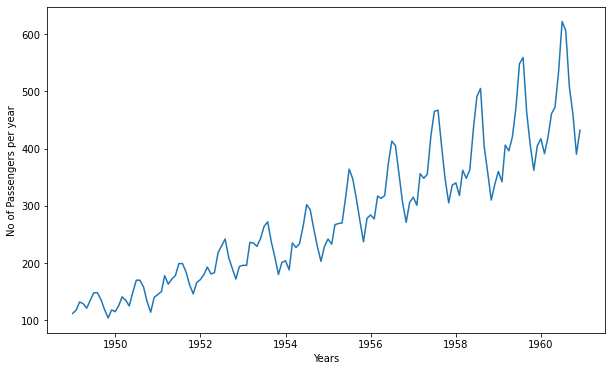

In [3]:
plt.plot(indexed_df)
plt.xlabel('Years')
plt.ylabel('No of Passengers per year')
plt.show()

### This data is not stationary because the mean is not constant. It changes year by year.

## Rolling statistics (to check statinarity)

In [4]:
roll_mean=indexed_df.rolling(window=12).mean()  # window means 12 months
roll_std=indexed_df.rolling(window=12).std()

print(roll_mean,roll_std)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


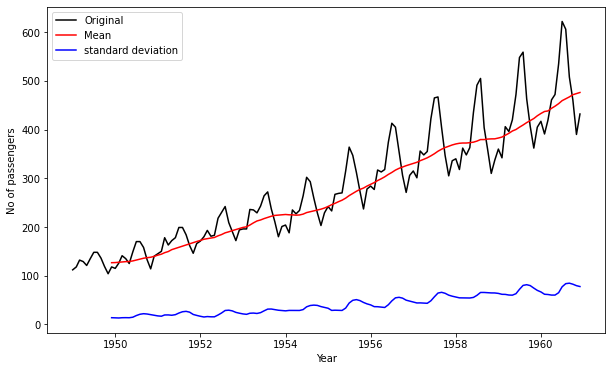

In [5]:
# Rolling plot

plt.plot(indexed_df,color='black',label='Original')
plt.plot(roll_mean,color='red',label='Mean')
plt.plot(roll_std,color='blue',label='standard deviation')
plt.xlabel('Year')
plt.ylabel('No of passengers')
plt.legend(loc='best')

### ADCF test

In [6]:
from statsmodels.tsa.stattools import adfuller

df_test=adfuller(indexed_df['#Passengers'],autolag='AIC')  

# autolag{“AIC”, “BIC”, “t-stat”, None}
# Method to use when automatically determining the lag.

#if None, then maxlag lags are used.

#if “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion.

#“t-stat” based choice of maxlag. Starts with maxlag and drops a lag until the t-statistic on the last lag length is significant using a 5%-sized test.

df_output=pd.Series(df_test[0:4],index=['Test Statistics','p-value','lag-used','No of observations used'])

for key,value in df_test[4].items():
    df_output['Critical values (%s)'%key] = value
    
print(df_output)
    


Test Statistics              0.815369
p-value                      0.991880
lag-used                    13.000000
No of observations used    130.000000
Critical values (1%)        -3.481682
Critical values (5%)        -2.884042
Critical values (10%)       -2.578770
dtype: float64


#### p-value>0.05, so data is not stationary 

Text(0, 0.5, 'log(no_of people)')

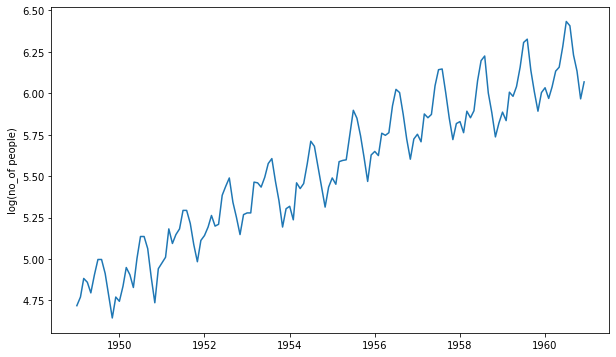

In [7]:
# Estimate the trend
indexed_df_log=np.log(indexed_df)
plt.plot(indexed_df_log)
plt.ylabel('log(no_of people)')


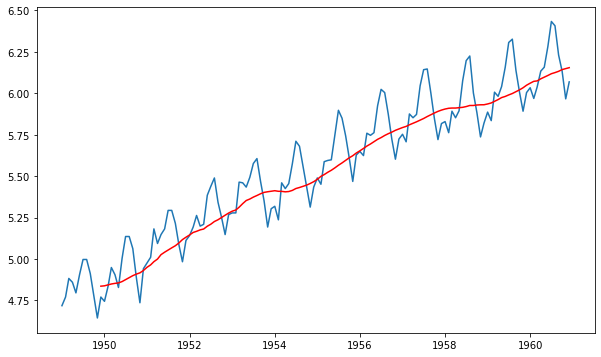

In [8]:
moving_mean=indexed_df_log.rolling(window=12).mean()  # window means 12 months
moving_std=indexed_df_log.rolling(window=12).std()

plt.plot(indexed_df_log)
plt.plot(moving_mean,color='red')

#### Again mean is not constant. So data is not stationary

### Here we are taking log and subtract to make the data stationary
#### But sometimes you need to take square root/ cube root and subtract. 
#### sometimes may be some other way to stationarize the data

In [9]:
df_log_minus_avg=indexed_df_log-moving_mean

# remove nan values
df_log_minus_avg.dropna(inplace=True)
df_log_minus_avg.head(15)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


In [10]:
# Function to plot rolling statistics and ADFC

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determine rolling statistics
    moving_avg=timeseries.rolling(window=12).mean()  # window means 12 months
    moving_std=timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.plot(timeseries,color='black',label='Original')
    plt.plot(moving_avg,color='red',label='Mean')
    plt.plot(moving_std,color='blue',label='standard deviation')
    plt.xlabel('Year')
    plt.ylabel('No of passengers')
    plt.legend(loc='best')
    
    # Perform dicky-fuller test
    
    
    df_test=adfuller(timeseries['#Passengers'],autolag='AIC')
    
    df_output=pd.Series(df_test[0:4],index=['Test Statistics','p-value','lag-used','No of observations used'])

    for key,value in df_test[4].items():
        df_output['Critical values (%s)'%key] = value
    
    print(df_output)
    
    

Test Statistics             -3.162908
p-value                      0.022235
lag-used                    13.000000
No of observations used    119.000000
Critical values (1%)        -3.486535
Critical values (5%)        -2.886151
Critical values (10%)       -2.579896
dtype: float64


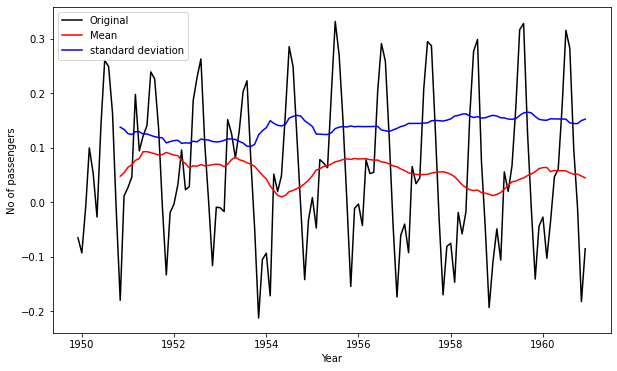

In [11]:
# Run the function
test_stationarity(df_log_minus_avg)

#### Here we see no such trend visually. So this data can be considered as stationary.Also p-value<0.05. 
#### Critical value ~ Test statistics value. i.e data is stationary.

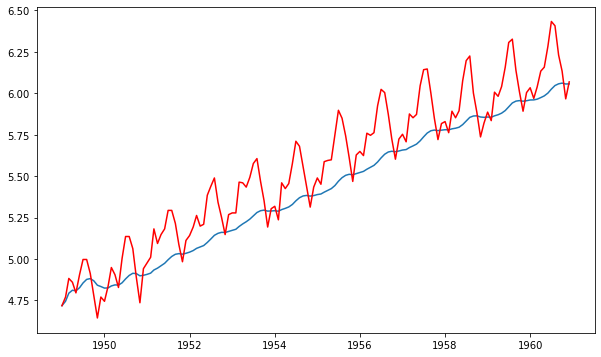

In [12]:
# Weighted average of time series in log scale

df_weighted_avg_log=indexed_df_log.ewm(halflife=12,min_periods=0,adjust=True).mean()   #ewm().mean() calculates weighted mean
plt.plot(df_weighted_avg_log)
plt.plot(indexed_df_log,color='red')




Test Statistics             -3.601262
p-value                      0.005737
lag-used                    13.000000
No of observations used    130.000000
Critical values (1%)        -3.481682
Critical values (5%)        -2.884042
Critical values (10%)       -2.578770
dtype: float64


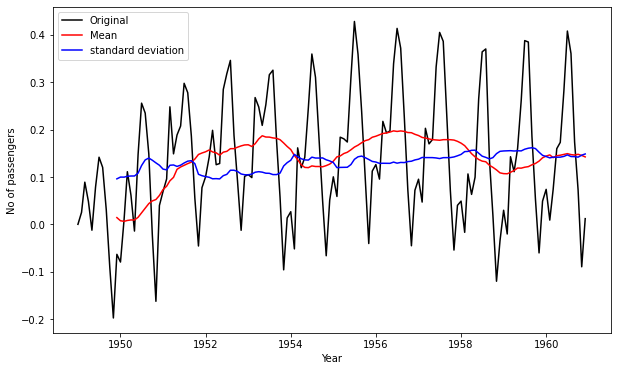

In [13]:
# Subtract log value and weighted average

df_log_minus_weighted_avg=indexed_df_log-df_weighted_avg_log

# Function call
test_stationarity(df_log_minus_weighted_avg)

#### p-value is even smaller. Rolling mean is also better than the previous visually.

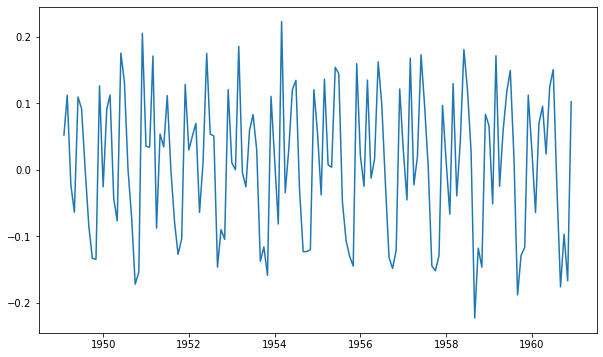

In [14]:
# Shift of the values

df_shifted_log_values=indexed_df_log-indexed_df_log.shift()

plt.plot(df_shifted_log_values)

Test Statistics             -2.717131
p-value                      0.071121
lag-used                    14.000000
No of observations used    128.000000
Critical values (1%)        -3.482501
Critical values (5%)        -2.884398
Critical values (10%)       -2.578960
dtype: float64


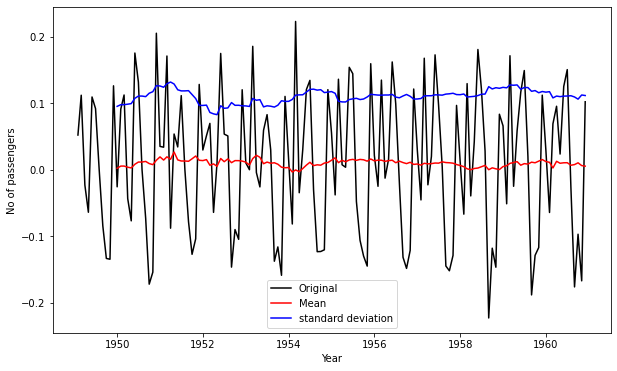

In [15]:
df_shifted_log_values.dropna(inplace=True)

test_stationarity(df_shifted_log_values)


#### So the data is stationary

#### Components of time series

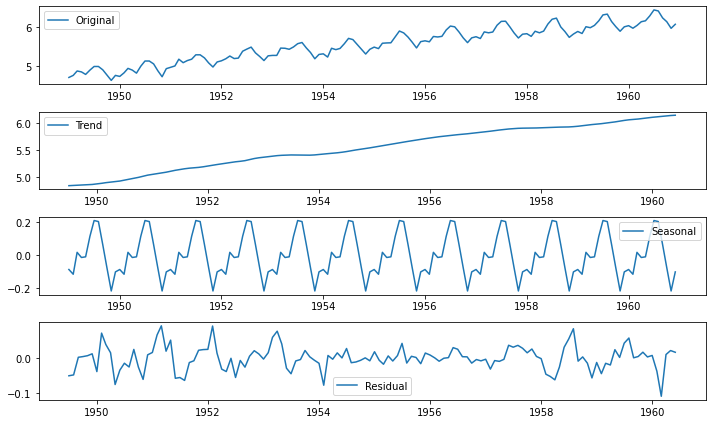

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(indexed_df_log)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(indexed_df_log,label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc='best')
plt.tight_layout()



KeyError: '#Passengers'

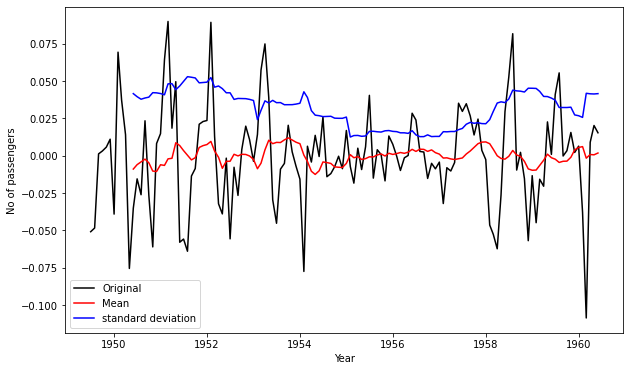

In [17]:
decomposedlogdata= residual
decomposedlogdata.dropna(inplace=True)

test_stationarity(decomposedlogdata)

#### This is not stationary.And in order to implement ARIMA model we will need to know p,q and d. d=1. For p and q we need to 
#### have ACF and PACF graphs. 

C:\Users\nilabha\Anaconda3\envs\carpredict\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


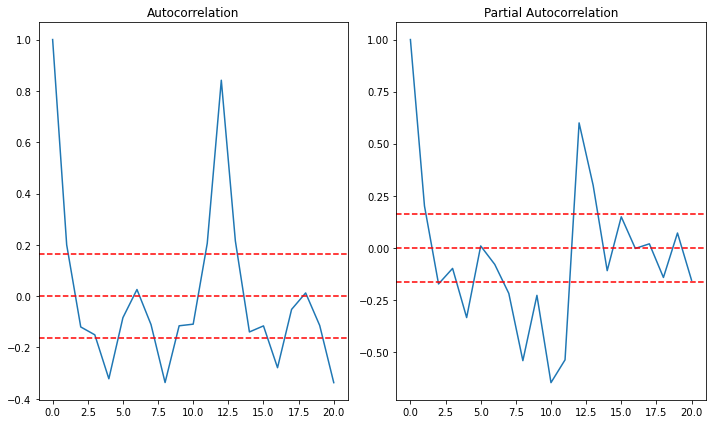

In [18]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_shifted_log_values,nlags=20)
lag_pacf=pacf(df_shifted_log_values,nlags=20,method='ols')

# Plot ACF
plt.subplot(121)
plt.plot(lag_acf)

plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shifted_log_values)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shifted_log_values)),linestyle='--',color='red')
plt.title('Autocorrelation')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)

plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_shifted_log_values)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_shifted_log_values)),linestyle='--',color='red')
plt.title('Partial Autocorrelation')
plt.tight_layout()


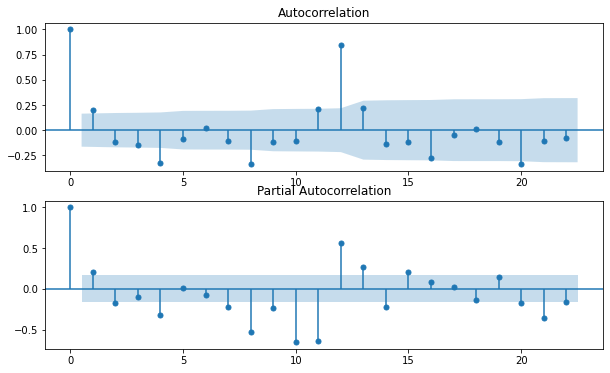

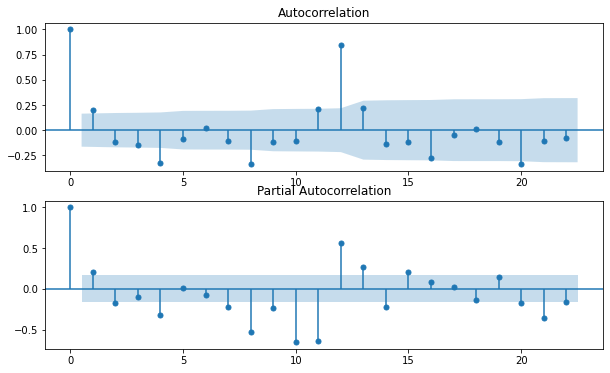

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(df_shifted_log_values,ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(df_shifted_log_values,ax=pyplot.gca())

## ARIMA Model

C:\Users\nilabha\Anaconda3\envs\carpredict\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\nilabha\Anaconda3\envs\carpredict\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR Model


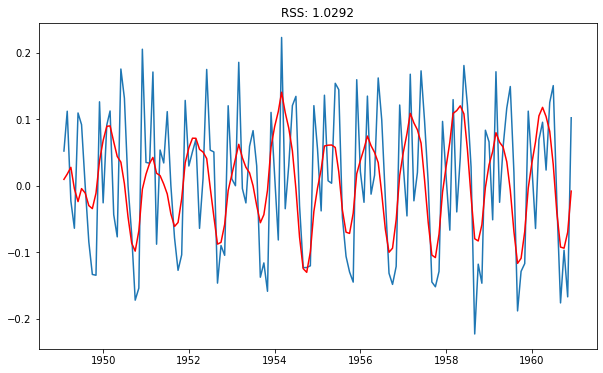

In [20]:
from statsmodels.tsa.arima_model import ARIMA

# AR model
model=ARIMA(indexed_df_log,order=(2,1,2))    #(p,d,q)
results_AR= model.fit(disp=-1)
plt.plot(df_shifted_log_values)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_shifted_log_values['#Passengers'])**2))  # RSS= Residual Sum of Squares
print('Plotting AR Model')



## Lesser the RSS better the model

C:\Users\nilabha\Anaconda3\envs\carpredict\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\nilabha\Anaconda3\envs\carpredict\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR Model


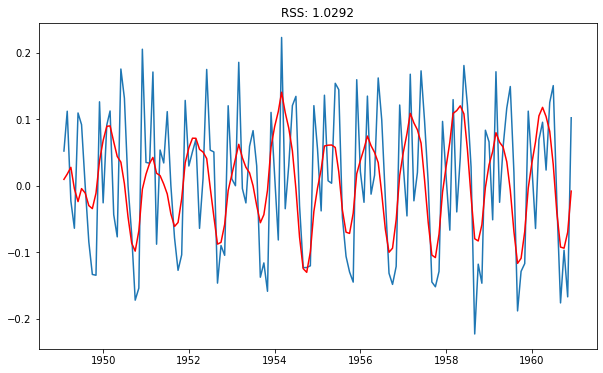

In [46]:
model=ARIMA(indexed_df_log,order=(2,1,2))    #(p,d,q)
results_ARIMA= model.fit(disp=-1)
plt.plot(df_shifted_log_values)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_shifted_log_values['#Passengers'])**2))  # RSS= Residual Sum of Squares
print('Plotting AR Model')

In [47]:
predictions_arima_diff=pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_arima_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [48]:
# Cumulative sum

predictions_arima_diff_cumsum=predictions_arima_diff.cumsum()  # means add with previous value
predictions_arima_diff_cumsum.head()


Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [49]:
predictions_arima_log=pd.Series(indexed_df_log['#Passengers'],index=indexed_df_log.index)
predictions_arima_log=predictions_arima_log.add(predictions_arima_diff_cumsum,fill_value=0)
predictions_arima_log.tail()

Month
1960-08-01    7.779430
1960-09-01    7.510682
1960-10-01    7.319585
1960-11-01    7.082410
1960-12-01    7.176562
dtype: float64

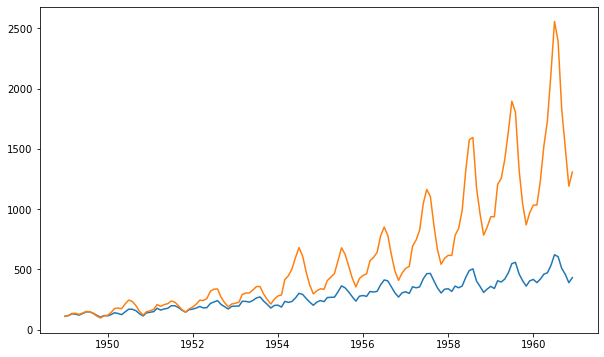

In [50]:
predictions_arima=np.exp(predictions_arima_log)
plt.plot(indexed_df)
plt.plot(predictions_arima)

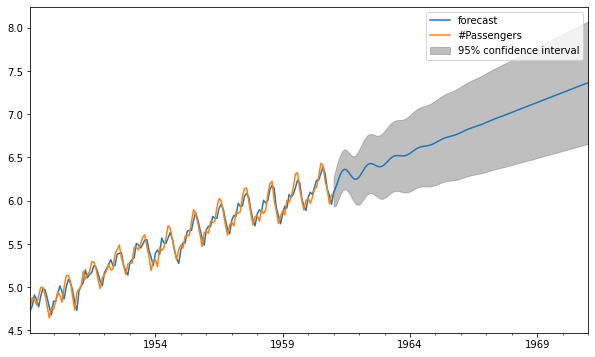

In [51]:
results_ARIMA.plot_predict(1,264)   # predicting for 10 years /120 months. 144+12=264
x=results_ARIMA.forecast(steps=120)
